In [107]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta

In [1]:
df = pd.read_csv('../bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df.head()

NameError: name 'pd' is not defined

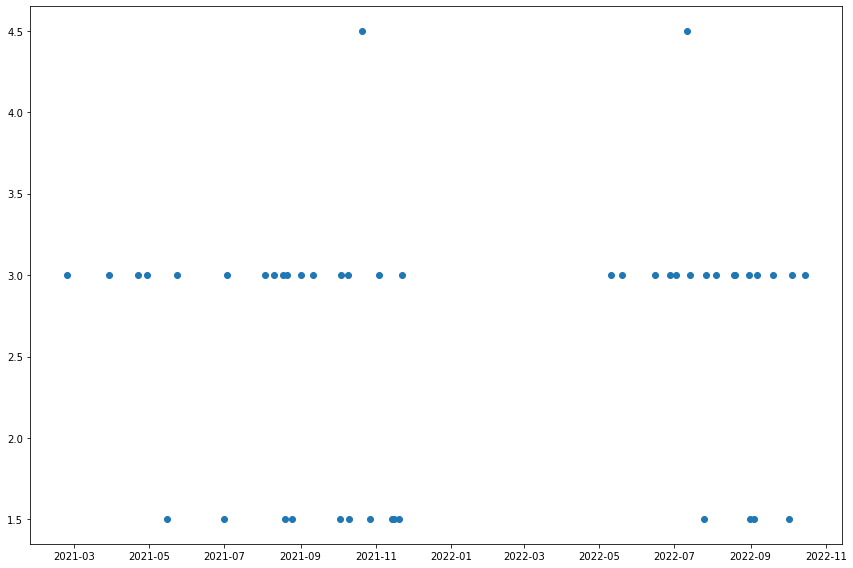

In [109]:
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.start_time, df.total_time_hours)
plt.tight_layout()
plt.show()

In [110]:
df = df.drop(['start_time', 'end_time'], axis=1)
df.head()

,total_time_hours
date,
2021-02-23,3.0
2021-03-29,3.0
2021-04-22,3.0
2021-04-29,3.0
2021-05-15,1.5


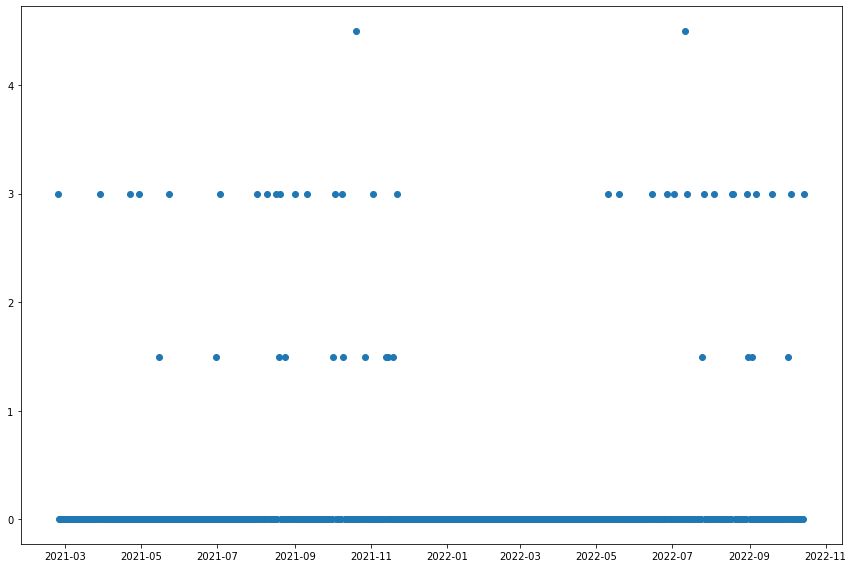

In [111]:
df = df.resample('D').mean().replace(np.nan, 0)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df.index, df)
plt.tight_layout()
plt.show()

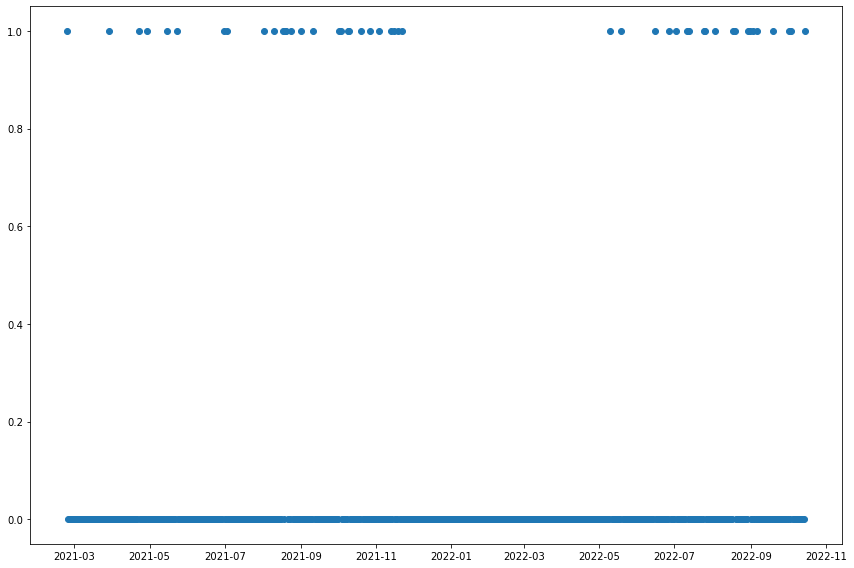

In [112]:
df_binary = df.copy()
df_binary[df_binary > 0] = 1
df_binary.rename(columns={'total_time_hours': 'booked'}, inplace=True)
fig = plt.figure(figsize=(12, 8))

plt.scatter(df_binary.index, df_binary)
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

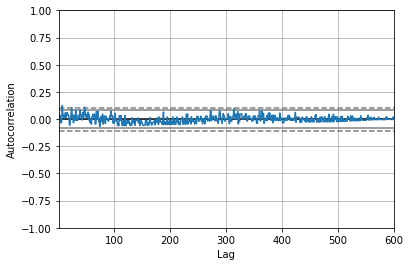

In [113]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_binary['booked'])

In [114]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_binary.booked.to_numpy(), order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -108.745
Date:                Thu, 20 Oct 2022   AIC                            229.490
Time:                        16:19:34   BIC                            255.862
Sample:                             0   HQIC                           239.757
                                - 600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7684      0.031    -24.873      0.000      -0.829      -0.708
ar.L2         -0.6050      0.040    -15.028      0.000      -0.684      -0.526
ar.L3         -0.4172      0.046     -9.033      0.0

In [115]:
forecast = model_fit.forecast(steps=31)
forecast

array([0.23163247, 0.21698002, 0.27591886, 0.27952474, 0.3018767 ,
       0.38566581, 0.29207911, 0.29347225, 0.30721674, 0.30775568,
       0.31121869, 0.31716393, 0.30619558, 0.30721879, 0.30953021,
       0.30948616, 0.30981519, 0.31010234, 0.30888792, 0.30915049,
       0.30947849, 0.30944077, 0.30945625, 0.30945206, 0.30932739,
       0.30937707, 0.3094178 , 0.30940715, 0.30940561, 0.30940237,
       0.30939081])

In [116]:
df_binary.iloc[-1]

booked    1.0
Name: 2022-10-15 00:00:00, dtype: float64

In [117]:
dates_forward = [{'date': datetime.today() + timedelta(days=i), 'booked': forecast[i-1]} for i in range(1, len(forecast))]
print(f"Most likely day to to book laundry slot: {dates_forward[np.argmax(forecast)]['date'].date()} ")

Most likely day to to book laundry slot: 2022-10-26 


In [118]:
preds = pd.DataFrame.from_dict(dates_forward).set_index('date')

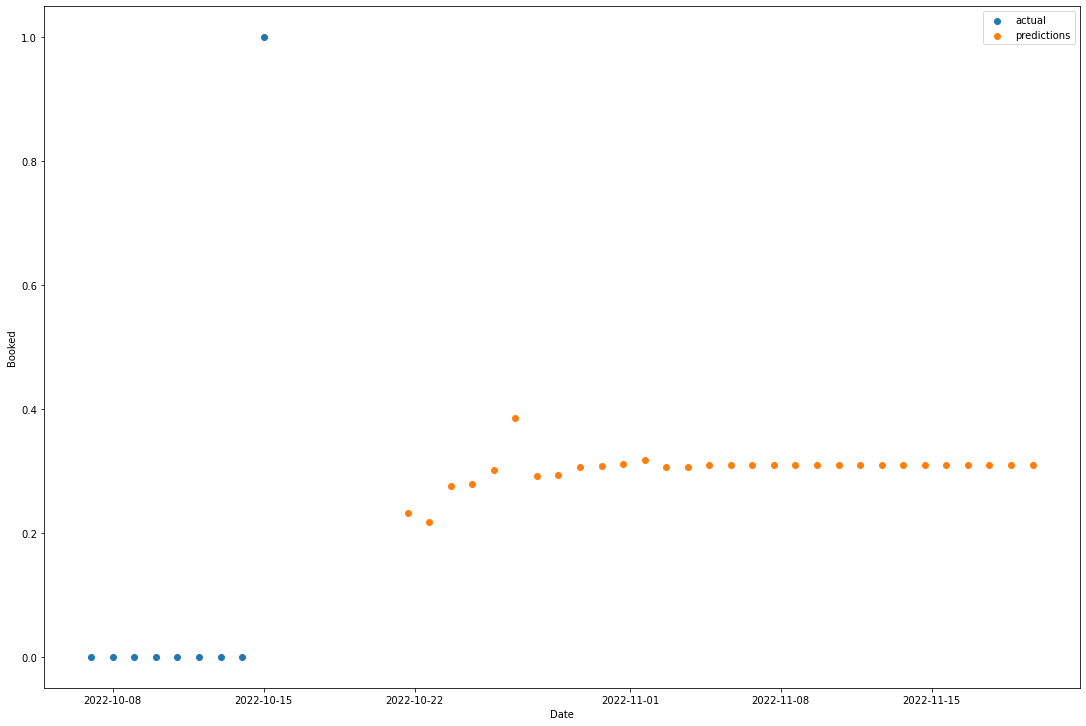

In [119]:
from datetime import date


fig = plt.figure(figsize=(15, 10))

smaller_window = df_binary.index > datetime.today() - timedelta(days=14)

plt.scatter(df_binary[smaller_window].index, df_binary[smaller_window], label='actual')
plt.scatter(preds.index, preds, label='predictions')
plt.tight_layout()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Booked')
plt.show()

In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


In [121]:
df_rolling = pd.read_csv('../bookings.csv', parse_dates=['date','start_time', 'end_time'], index_col=[0])
df_rolling = df_rolling.drop(['start_time', 'end_time'], axis=1)
df_rolling[df_rolling > 0] = 1
df_rolling.head()

,total_time_hours
date,
2021-02-23,1.0
2021-03-29,1.0
2021-04-22,1.0
2021-04-29,1.0
2021-05-15,1.0


In [122]:
df_rolling = df_rolling.reset_index()
df_rolling['days_since_booked'] = (df_rolling.date - np.roll(df_rolling.date, shift=1))
df_rolling.days_since_booked = df_rolling.days_since_booked.apply(lambda x: x.days)
df_rolling.rename(columns={'total_time_hours': 'booked'}, inplace=True)
# drop first row
df_rolling = df_rolling.drop(df_rolling.index[0])
df_rolling.head()


,date,booked,days_since_booked
1,2021-03-29,1.0,34
2,2021-04-22,1.0,24
3,2021-04-29,1.0,7
4,2021-05-15,1.0,16
5,2021-05-23,1.0,8


In [123]:
df_rolling_filled_dates = df_rolling.set_index('date').resample('D').mean()
# increment by 1 each day until the next booking    
for idx, row in df_rolling_filled_dates.iterrows():
    if row.booked == 1:
        counter = 1
    else:
        row.days_since_booked = counter
        counter += 1
df_rolling_filled_dates.replace(np.nan, 0, inplace=True)
df_rolling_filled_dates.head(0)

,booked,days_since_booked
date,,


In [124]:
df_rolling_filled_dates = df_rolling_filled_dates.reset_index()
#df_rolling_filled_dates["isWeekend"] = df_rolling_filled_dates.date.apply(lambda x: x.weekday() > 4).astype(int)
#df_rolling_filled_dates["month"] = df_rolling_filled_dates.date.apply(lambda x: x.month).astype(int)
df_rolling_filled_dates.head()

,date,booked,days_since_booked
0,2021-03-29,1.0,34.0
1,2021-03-30,0.0,1.0
2,2021-03-31,0.0,2.0
3,2021-04-01,0.0,3.0
4,2021-04-02,0.0,4.0


In [125]:
df_rolling_filled_dates.days_since_booked.value_counts()

1.0      45
2.0      39
3.0      35
4.0      31
5.0      29
         ..
75.0      1
74.0      1
73.0      1
72.0      1
169.0     1
Name: days_since_booked, Length: 169, dtype: int64

In [138]:
df_rolling_filled_dates.corr()

,booked,days_since_booked
booked,1.000000,-0.009447
days_since_booked,-0.009447,1.000000


In [137]:
# Use only data after 2022-05-11
df_rolling_filled_dates = df_rolling_filled_dates[(df_rolling_filled_dates.date > datetime(2022, 5, 11)) | (df_rolling_filled_dates.date < datetime(2022, 1, 1))]

In [128]:
lr = LogisticRegression(class_weight='balanced')

X, y = df_rolling_filled_dates.drop(["date", "booked"], axis=1), df_rolling_filled_dates.booked.values
# split 
N = len(X)
print(N)
X_train, X_test, y_train, y_test = X[:int(N*0.8)], X[int(N*0.8):], y[:int(N*0.8)], y[int(N*0.8):]
print('Length of training set: ', len(X_train))
print('Length of test set: ', len(X_test))
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
print("F1 score", f1_score(y_test, lr.predict(X_test)))

435
Length of training set:  348
Length of test set:  87
F1 score 0.1647058823529412


In [129]:
asd = X_test.copy()
asd['pred'] = lr.predict_proba(X_test)[:, 1]
asd.head(10)

,days_since_booked,pred
479,8.0,0.501589
480,9.0,0.500981
481,10.0,0.500372
482,11.0,0.499764
483,12.0,0.499155
484,1.0,0.505849
485,1.0,0.505849
486,2.0,0.505240
487,3.0,0.504632
488,4.0,0.504023


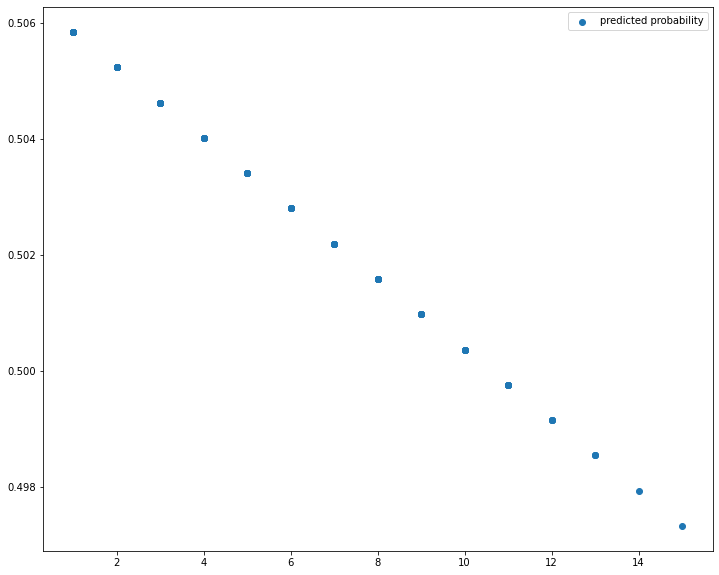

In [130]:
vals = np.arange(0, 90).reshape(-1, 1)
plt.figure(figsize=(12, 10))
plt.scatter(X_test.days_since_booked, lr.predict_proba(X_test)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.show()


In [131]:
# get date from the last row of df_rolling_filled_dates
latest_booking_date = df_rolling_filled_dates.iloc[-1].date.date()

if latest_booking_date > date.today():
    print('Laundry slot already booked in the future. No need to compute probability.')

dates_forward = [latest_booking_date + timedelta(days=i) for i in range(0, 30)]


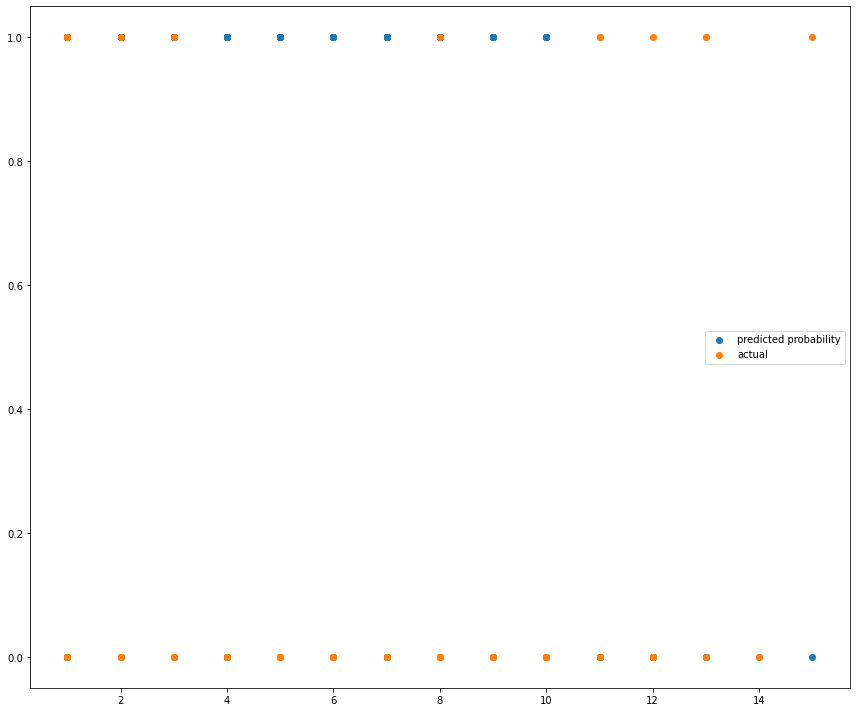

In [132]:
plt.figure(figsize=(12, 10))
plt.scatter(X_test.days_since_booked, lr.predict(X_test), label='predicted probability')
plt.scatter(X_test.days_since_booked, y_test, label='actual')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.tight_layout()
plt.savefig('current_predictions.png' ,dpi=150, bbox_inches = "tight")
plt.show()


In [133]:
X_test

,days_since_booked
479,8.0
480,9.0
481,10.0
482,11.0
483,12.0
...,...
561,7.0
562,8.0
563,9.0
564,10.0


0.8505747126436781
F1 0.0


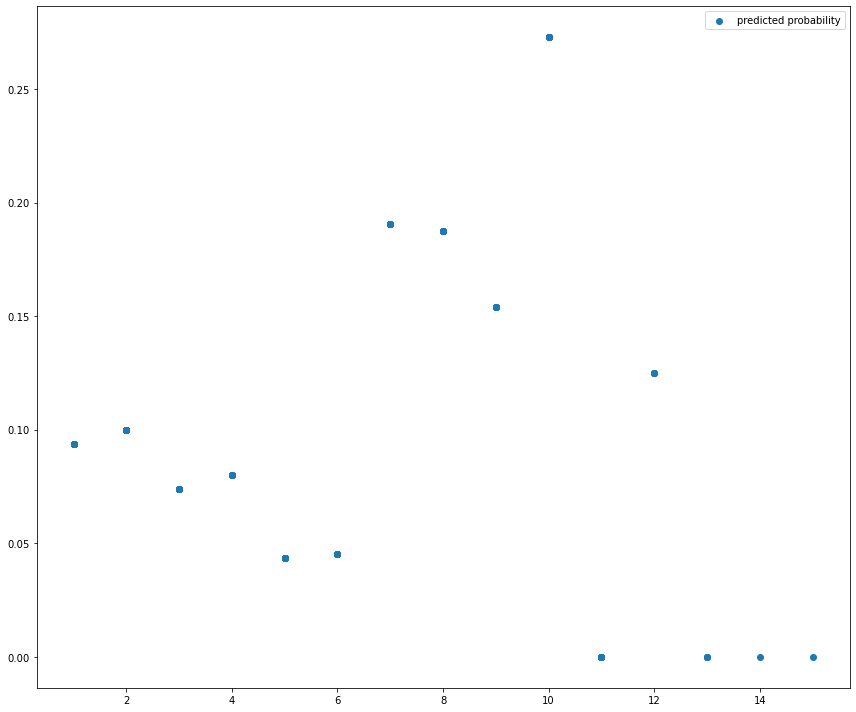

In [134]:
# tree

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(tree.score(X_test, y_test))
print("F1" , f1_score(y_test, tree.predict(X_test)))
plt.figure(figsize=(12, 10))
plt.scatter(X_test.days_since_booked, tree.predict_proba(X_test)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.tight_layout()
plt.savefig('current_predictions.png' ,dpi=150, bbox_inches = "tight")
plt.show()


[16:19:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8505747126436781
F1 score 0.0


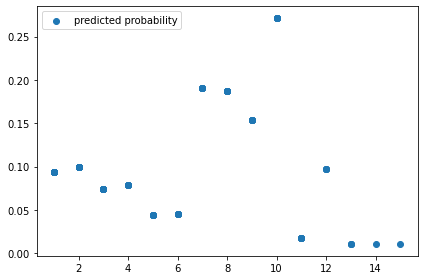

In [135]:
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, f1_score
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)
print(xgb.score(X_test, y_test))
print("F1 score", f1_score(y_test, xgb.predict(X_test)))
plt.scatter(X_test.days_since_booked, xgb.predict_proba(X_test)[:, 1], label='predicted probability')
#plt.scatter(vals[y_test==1], y_test[y_test==1], label='actual')
plt.legend()
plt.tight_layout()
plt.savefig('current_predictions.png' ,dpi=150, bbox_inches = "tight")
plt.show()


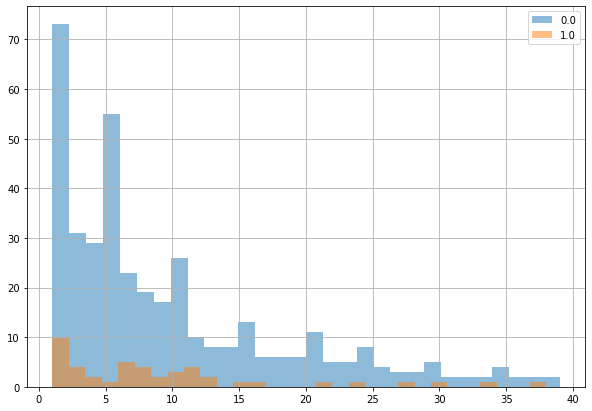

In [136]:
# random forest
df_rolling_filled_dates.groupby('booked').days_since_booked.hist(alpha=0.5, bins=30, figsize=(10, 7), legend=True)
plt.show()